# 1. Stating and refining the question.

A suitable question is "Are Doctors assigned to rep close to each other? (Descriptive)"

Epicycle:
- Expectations: The question is answerable and useful
- Collection: Looking at the dataset and collecting information about the company objectives.
    - conclusion: Doctors assigned to rep are better to be close to increase the performance of the rep, using the geolocations of each doctor we can know how close are the assigned doctors, However a lot of companies still do not use the new geolocation feature hence we won't be able to calculate the exact distance between assigned doctors for some companies.
- Match: Mismatch between the data and the question, the question is not answerable with the given data.

We can edit the question to be "Are Doctors assigned to rep in the same area? (Descriptive)"

Epicycle:
- Expectations: The question is answerable and useful
- Collection: Looking at the dataset and collecting information about the company objectives.
    - conclusion: Doctors assigned to rep are better to be close to increase the performance of the rep, this time we can use the location of each doctor instead of the geolocation to know how many different areas are the assigned doctors in.
- Match: Match between the data and the question, the question is answerable and useful.

# 2. Exploratory data analysis.

Epicycle:
- Expectations: we should have a dataset of representatives’ visits with the location of the visit, we should not display any sensitive information of the users, we should not have missing values as the app forces the user to enter the complete information, however there could be some outliers due to users' mistakes.
- Collection: Exploring and vislualizing the dataset, looking for missing values and outliers, and also looking for any sensitive information that should not be displayed.
    - conclusion: indeed we have a dataset of representatives’ visits with the location of the visit, we carefully drop any sensitive information before beginning the analysis, we have no missing values, however we have some outliers that we should take care of.
- Match: indeed expectations and data collection match.


##### Imports

In [7]:
import os
from pymongo import MongoClient
from dotenv import load_dotenv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats

##### First let's connect to mongoDB.

In [8]:
# Load environment variables from .env file
load_dotenv()

# Retrieve the connection string from the environment variables
connection_string = os.getenv("CONNECTION_STRING")

# Connect to the MongoDB server
client = MongoClient(connection_string)

# Connect to the database
db = client['tacitapp']

# Connect to the collection
visits = db['visits']

##### Get the data we need.


In [9]:
# Define the pipeline
pipeline = [
    {
        '$project': {
            '_id': 0, 
            'representative_id': '$user.id', 
            'representative_name': '$user.name', 
            'country': '$location.country', 
            'province': '$location.province', 
            'city': '$location.city', 
            'date': '$createdAt'
        }
    }
]

In [10]:
# Execute the pipeline
result = visits.aggregate(pipeline)

# Store the result in a dataframe
df = pd.DataFrame(result)

##### Privacy note:
For data sensetive reasons, we will drop the representative name

In [11]:
# View columns
print(df.columns)
# Drop columns
df.drop(['representative_name'], axis=1, inplace=True)
# View columns
print(df.columns)


Index(['representative_id', 'representative_name', 'country', 'province',
       'city', 'date'],
      dtype='object')
Index(['representative_id', 'country', 'province', 'city', 'date'], dtype='object')


##### Handle missing values
we can see that there are no missing values in the dataset.
and that is mainly because the system does not allow the rep to submit the visit if he did not fill all the required fields.

In [12]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
representative_id,0,0.0
country,0,0.0
province,0,0.0
city,0,0.0
date,0,0.0


##### some statistics about the data

In [13]:
# Display first 10 rows
df.head(10)

,representative_id,country,province,city,date
0,603a2ef7d1fce046a5e63f8a,EGYPT,GIZA,HARAM3,2022-09-27 00:49:15.517
1,603a2ef7d1fce046a5e63f8a,EGYPT,GIZA,HARAM2,2022-09-27 00:49:18.861
2,5d665baa0c15a90015e6e925,KSA,CENTRAL,RIYADH,2022-09-27 01:15:41.275
3,5d665baa0c15a90015e6e925,KSA,CENTRAL,RIYADH,2022-09-27 01:15:46.198
4,5edbe555d290bc0017f51461,EGYPT,GHARBIA,GHARBIA1,2022-09-27 01:21:29.457
5,5edbdfcdbe2e390017c68c6d,EGYPT,ALEXANDRIA,EAST ALEX3,2022-09-27 01:28:28.476
6,5edbdfcdbe2e390017c68c6d,EGYPT,ALEXANDRIA,EAST ALEX1,2022-09-27 01:29:02.202
7,5edbdfcdbe2e390017c68c6d,EGYPT,ALEXANDRIA,EAST ALEX1,2022-09-27 01:29:08.047
8,5edbdfcdbe2e390017c68c6d,EGYPT,ALEXANDRIA,EAST ALEX1,2022-09-27 01:29:14.133
9,5edbe555d290bc0017f51461,EGYPT,GHARBIA,GHARBIA1,2022-09-27 01:37:41.277


In [14]:
# Let's keep only the day date
df['date'] = pd.to_datetime(df['date']).dt.date

In [15]:
# Display first 10 rows
df.head(10)

,representative_id,country,province,city,date
0,603a2ef7d1fce046a5e63f8a,EGYPT,GIZA,HARAM3,2022-09-27
1,603a2ef7d1fce046a5e63f8a,EGYPT,GIZA,HARAM2,2022-09-27
2,5d665baa0c15a90015e6e925,KSA,CENTRAL,RIYADH,2022-09-27
3,5d665baa0c15a90015e6e925,KSA,CENTRAL,RIYADH,2022-09-27
4,5edbe555d290bc0017f51461,EGYPT,GHARBIA,GHARBIA1,2022-09-27
5,5edbdfcdbe2e390017c68c6d,EGYPT,ALEXANDRIA,EAST ALEX3,2022-09-27
6,5edbdfcdbe2e390017c68c6d,EGYPT,ALEXANDRIA,EAST ALEX1,2022-09-27
7,5edbdfcdbe2e390017c68c6d,EGYPT,ALEXANDRIA,EAST ALEX1,2022-09-27
8,5edbdfcdbe2e390017c68c6d,EGYPT,ALEXANDRIA,EAST ALEX1,2022-09-27
9,5edbe555d290bc0017f51461,EGYPT,GHARBIA,GHARBIA1,2022-09-27


In [16]:
# Let's normalize country, province and city by removing spaces and lowercasing
df['country'] = df['country'].str.lower().str.strip()
df['province'] = df['province'].str.lower().str.strip()
df['city'] = df['city'].str.lower().str.strip()

In [17]:
# Create location which is a concatenation of country, province and city
df['location'] = df['country'] + '-' + df['province'] + '-' + df['city']

In [18]:
df.head(10)

,representative_id,country,province,city,date,location
0,603a2ef7d1fce046a5e63f8a,egypt,giza,haram3,2022-09-27,egypt-giza-haram3
1,603a2ef7d1fce046a5e63f8a,egypt,giza,haram2,2022-09-27,egypt-giza-haram2
2,5d665baa0c15a90015e6e925,ksa,central,riyadh,2022-09-27,ksa-central-riyadh
3,5d665baa0c15a90015e6e925,ksa,central,riyadh,2022-09-27,ksa-central-riyadh
4,5edbe555d290bc0017f51461,egypt,gharbia,gharbia1,2022-09-27,egypt-gharbia-gharbia1
5,5edbdfcdbe2e390017c68c6d,egypt,alexandria,east alex3,2022-09-27,egypt-alexandria-east alex3
6,5edbdfcdbe2e390017c68c6d,egypt,alexandria,east alex1,2022-09-27,egypt-alexandria-east alex1
7,5edbdfcdbe2e390017c68c6d,egypt,alexandria,east alex1,2022-09-27,egypt-alexandria-east alex1
8,5edbdfcdbe2e390017c68c6d,egypt,alexandria,east alex1,2022-09-27,egypt-alexandria-east alex1
9,5edbe555d290bc0017f51461,egypt,gharbia,gharbia1,2022-09-27,egypt-gharbia-gharbia1


In [19]:
# for each date and representative, count the number of different locations
df = df.groupby(['date', 'representative_id']).agg({'location': 'nunique'}).reset_index()

In [20]:
df.head(10)

,date,representative_id,location
0,2022-09-27,5d665baa0c15a90015e6e925,1
1,2022-09-27,5d665cee0c15a90015e6e927,5
2,2022-09-27,5d665d1a0c15a90015e6e928,3
3,2022-09-27,5da46821565e29001518856e,2
4,2022-09-27,5da4687f565e290015188570,2
5,2022-09-27,5da46a0b565e290015188578,1
6,2022-09-27,5da46b91565e29001518857d,2
7,2022-09-27,5da46cb6565e290015188596,4
8,2022-09-27,5da46ce7565e290015188597,8
9,2022-09-27,5da46dd9565e29001518859c,9


##### outliers

In [21]:
df['location'].describe()

count    7060.000000
mean        2.894476
std         2.411910
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        27.000000
Name: location, dtype: float64

C:\Users\batyo\AppData\Local\Temp\ipykernel_9976\2341467965.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['location'])


<Axes: xlabel='location', ylabel='Density'>

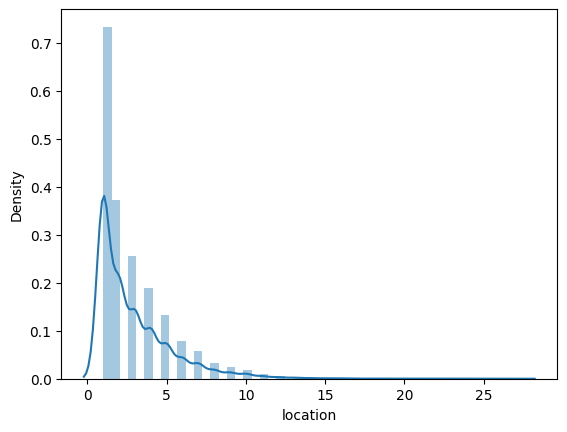

In [22]:
# histogram of the number of locations
sns.distplot(df['location'])

In [23]:
#skewness and kurtosis
print("Skewness: %f" % df['location'].skew())
print("Kurtosis: %f" % df['location'].kurt())

Skewness: 2.032945
Kurtosis: 6.565557


<Axes: xlabel='location'>

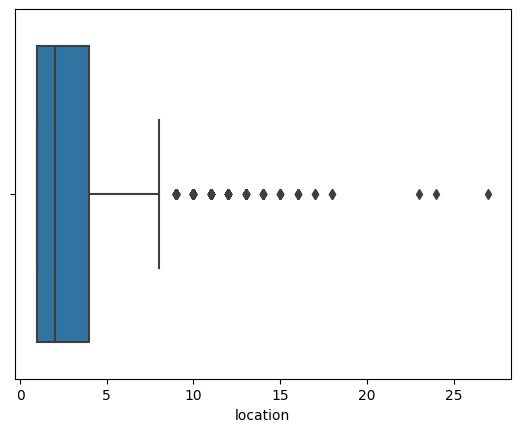

In [24]:
# let's build a boxplot to check for outliers
sns.boxplot(x=df['location'])

from histogram, skewness and kurtosis, we notice that: <br>
There are outliers in the data, for example a representative cannot go to 27 different places in the same day.

let's use the IQR method to detect and remove them

In [25]:
# Calculate the interquartile range (IQR)
Q1 = df['location'].quantile(0.25)
Q3 = df['location'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove the outliers from the DataFrame
df_outliers_removed = df[(df['location'] >= lower_bound) & (df['location'] <= upper_bound)]
# Remove the outliers from the DataFrame
outliers = df[(df['location'] < lower_bound) | (df['location'] > upper_bound)]

print("Original DataFrame:")
print(df)
print("\nDataFrame with outliers removed:")
print(df_outliers_removed)

Original DataFrame:
            date         representative_id  location
0     2022-09-27  5d665baa0c15a90015e6e925         1
1     2022-09-27  5d665cee0c15a90015e6e927         5
2     2022-09-27  5d665d1a0c15a90015e6e928         3
3     2022-09-27  5da46821565e29001518856e         2
4     2022-09-27  5da4687f565e290015188570         2
...          ...                       ...       ...
7055  2023-04-30  63fe363716a46142165545d4         4
7056  2023-04-30  63fe36e016a46142165545da         4
7057  2023-04-30  640485c28f583f4266ddcb99         1
7058  2023-04-30  64172e66ae90367af9eefbf5         1
7059  2023-04-30  6436a6c8bb05fa24a6e7f68d         4

[7060 rows x 3 columns]

DataFrame with outliers removed:
            date         representative_id  location
0     2022-09-27  5d665baa0c15a90015e6e925         1
1     2022-09-27  5d665cee0c15a90015e6e927         5
2     2022-09-27  5d665d1a0c15a90015e6e928         3
3     2022-09-27  5da46821565e29001518856e         2
4     2022-09-27  5d

C:\Users\batyo\AppData\Local\Temp\ipykernel_9976\361173475.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_outliers_removed['location'])


<Axes: xlabel='location', ylabel='Density'>

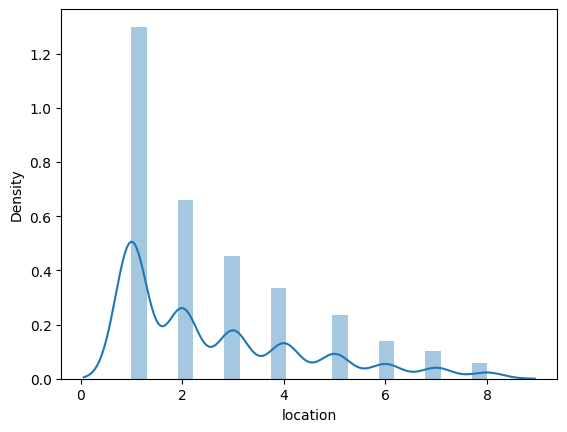

In [26]:
# histogram of the number of locations
sns.distplot(df_outliers_removed['location'])

In [27]:
# skewness and kurtosis
print("Skewness: %f" % df_outliers_removed['location'].skew())
print("Kurtosis: %f" % df_outliers_removed['location'].kurt())

Skewness: 1.122454
Kurtosis: 0.437992


<Axes: xlabel='location'>

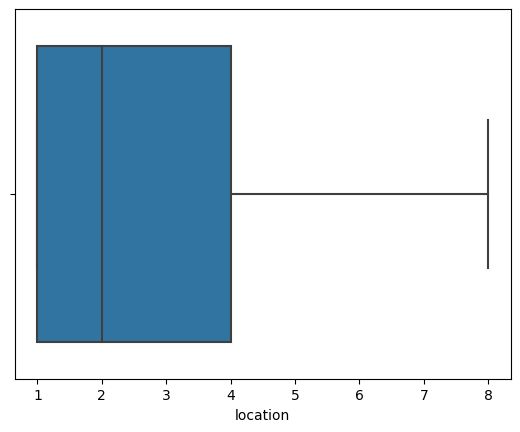

In [28]:
# let's build a boxplot
sns.boxplot(x=df_outliers_removed['location'])

In [29]:
df = df_outliers_removed

# 3. Build a model.

However, we don't need a model to answer our question, we can simply calculate the average number of different locations assigned to each representative per day.

Epicycle:
- Expectations: After preprocessing and visualizing the data, we should be able to answer the question by grouping on the representative and day columns and calculate the average of the location column.
- Collection: Indeed we managed to answer the question.
- Match: Indeed expectations and data collection match.


In [30]:
# Calculatet the averge number of location visited per day for each representative
df = df.groupby(['representative_id']).agg({'location': 'mean'}).reset_index()
print(df)

            representative_id  location
0    5d665baa0c15a90015e6e925  1.281250
1    5d665cee0c15a90015e6e927  6.210526
2    5d665d1a0c15a90015e6e928  2.127273
3    5d665d440c15a90015e6e929  2.969697
4    5da46821565e29001518856e  1.864662
..                        ...       ...
201  640485c28f583f4266ddcb99  1.043478
202  64172e66ae90367af9eefbf5  1.086957
203  6436a5fbbb05fa24a6e7f674  4.000000
204  6436a685bb05fa24a6e7f685  3.000000
205  6436a6c8bb05fa24a6e7f68d  1.833333

[206 rows x 2 columns]


# 4. Interpret the results.

Epicycle:
- Expectations: Useful insights and interpretations of the results, also we should be able to get the distribution of the average number of different locations assigned to each representative per day.
- Collection: Indeed we can get the distribution and visualize it, and we can see that the average number of different locations visited by a rep in a single day varies from a representative to another.
So we can conclude that some representatives have to travel more than others and that can be exhausting, time consuming and can affect the performance of the rep.
- Match: Indeed expectations and data collection match.

# 5. Communicate the results.

Epicycle:
- Expectations: The results should be communicated in a clear and concise way, we should be able to communicate the results in a way that is understandable by the stakeholders.
- Collection: Indeed we can use boxplot and barplot to visualize the distribution and communicate the results.
- Match: Indeed expectations and data collection match.

<Axes: xlabel='location'>

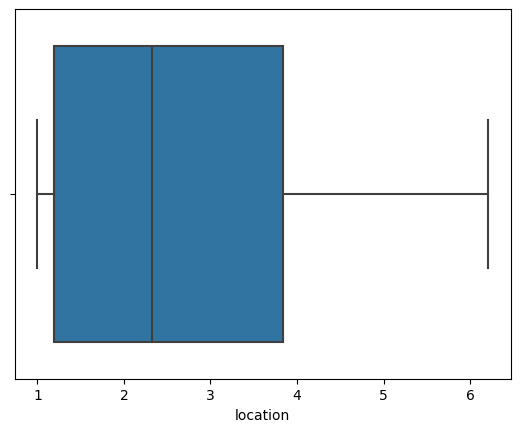

In [97]:
# Build a boxplot
sns.boxplot(x=df['location'])

<Axes: xlabel='representative_id', ylabel='location'>

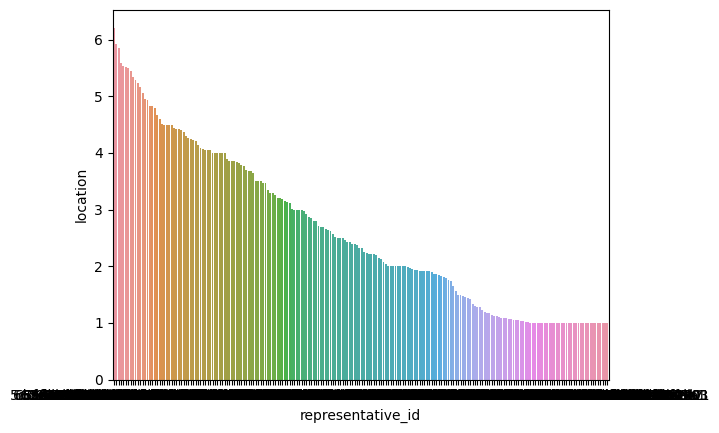

In [31]:
# sort the dataframe by location
df = df.sort_values(by=['location'], ascending=False)
# Build Bar chart
sns.barplot(x=df['representative_id'], y=df['location'])

C:\Users\batyo\AppData\Local\Temp\ipykernel_9976\363229656.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['location'])


<Axes: xlabel='location', ylabel='Density'>

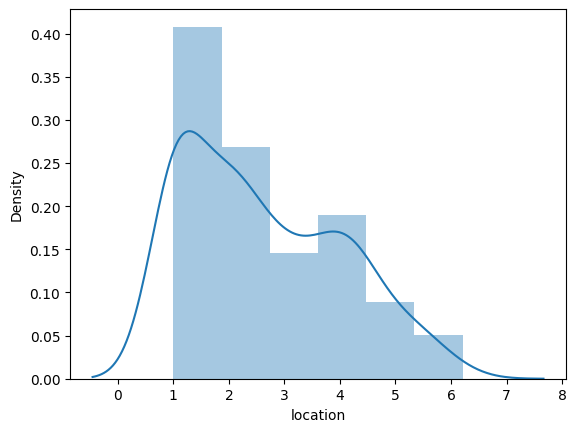

In [32]:
# distribution of the number of locations visited per day
sns.distplot(df['location'])

we can see that the average number different locations visited by a rep in a single day varies from a representative to another.

So we can conclude that some representatives have to travel more than others and that can be excausting, time consuming and can affect the performance of the rep.